In [28]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, recall_score, confusion_matrix
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.manifold import SpectralEmbedding
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

In [7]:
pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ---------------------------------------- 88.8/88.8 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/2.8 MB 11.8 MB/s eta 0:00:01
   ------------ --------------------------- 0.9/2.8 MB 11.6 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.8 MB 11.3 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.8 MB 11.1 MB/s eta 0:00:01
   ----------------------------------- ---- 2.5/2.8 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB 3.1 MB/s eta 0:00:00
   ---------------


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: C:\Users\Nils\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


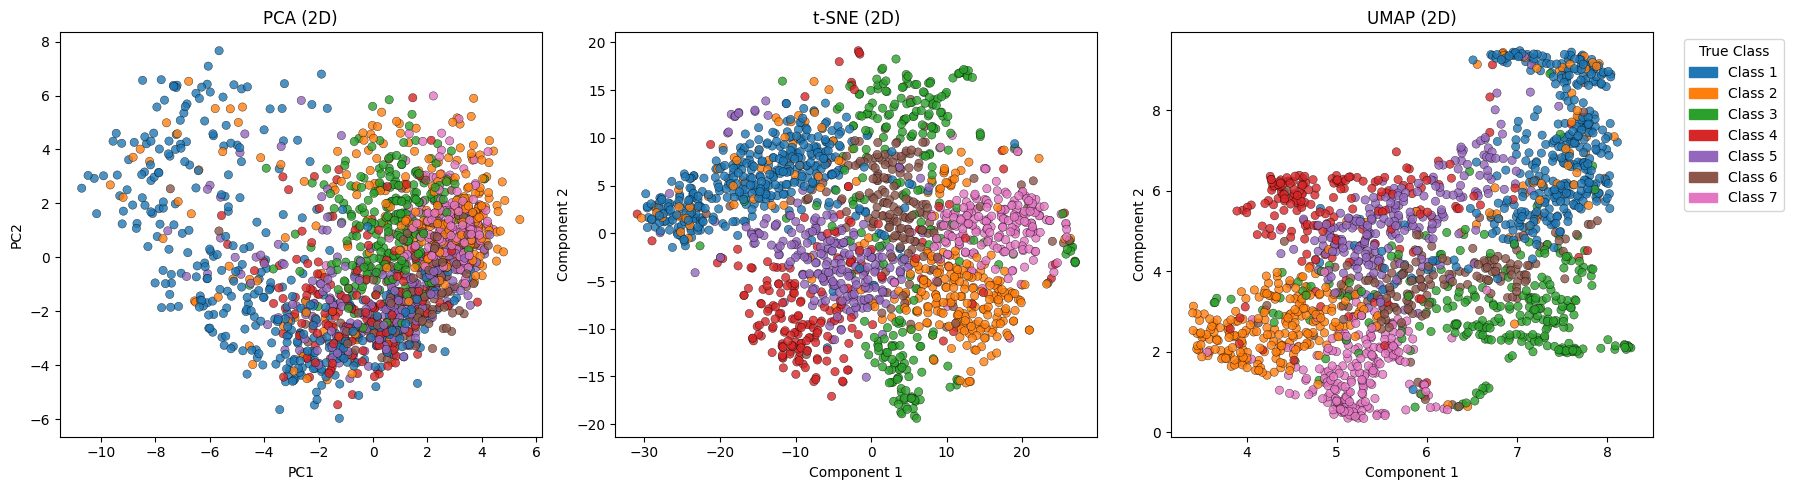

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Load and split the data
df = pd.read_csv("Cancer2025exam.csv")
X = df.drop(columns=["V1"])
y = df["V1"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled)
# Apply t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42).fit_transform(X_scaled)
# Apply UMAP
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled)

# Generate consistent color mapping
unique_classes = np.unique(y)
cmap = plt.get_cmap('tab10')
class_to_color = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
colors = np.array([class_to_color[cls] for cls in y])

# Plotting
plt.figure(figsize=(18, 5))

# PCA
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], color=colors, alpha=0.8, edgecolor='k', linewidth=0.3)
plt.title("PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# t-SNE
plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors, alpha=0.8, edgecolor='k', linewidth=0.3)
plt.title("t-SNE (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# UMAP
plt.subplot(1, 3, 3)
plt.scatter(X_umap[:, 0], X_umap[:, 1], color=colors, alpha=0.8, edgecolor='k', linewidth=0.3)
plt.title("UMAP (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Shared legend
from matplotlib.patches import Patch
legend_handles = [Patch(color=class_to_color[cls], label=f"Class {cls}") for cls in unique_classes]
plt.legend(handles=legend_handles, title="True Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [29]:
class FullPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pipeline = make_pipeline(
            PowerTransformer(),
            StandardScaler(),
            PCA(n_components=0.8, svd_solver='full')
        )

    def fit(self, X, y=None):
        self.pipeline.fit(X)
        return self

    def transform(self, X):
        return self.pipeline.transform(X)
class ResampleWrapper(BaseEstimator):
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y):
        df = pd.DataFrame(X)
        df['label'] = y.values if hasattr(y, 'values') else y

        min_class_size = df['label'].value_counts().min()
        balanced_df = pd.concat([
            resample(group, replace=False, n_samples=min_class_size, random_state=42)
            for _, group in df.groupby('label')
        ])
        X_balanced = balanced_df.drop(columns='label').values
        y_balanced = balanced_df['label'].values

        self.classifier_ = clone(self.classifier)
        self.classifier_.fit(X_balanced, y_balanced)
        return self

    def predict(self, X):
        return self.classifier_.predict(X)
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    TN = []
    FP = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        TN.append(tn)
        FP.append(fp)
    specificity = np.mean([tn / (tn + fp) if (tn + fp) > 0 else 0 for tn, fp in zip(TN, FP)])
    return specificity

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity_macro': make_scorer(recall_score, average='macro'),
    'specificity_macro': make_scorer(specificity_score)
}
def create_pipeline(classifier, use_preprocessing=True, use_resampling=True):
    steps = []
    
    if use_preprocessing:
        steps.append(('preprocess', FullPreprocessor()))
    
    if use_resampling:
        steps.append(('resample_clf', ResampleWrapper(classifier)))
    else:
        steps.append(('classifier', classifier))
    
    return Pipeline(steps)



In [63]:
import os
import pandas as pd
import numpy as np
from time import time
from itertools import product
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.utils import resample

# --- Preprocessing placeholder ---
class FullPreprocessor:
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std()
        return self
    def transform(self, X):
        return (X - self.means) / self.stds

# Load data
base_df = pd.read_csv("Cancer2025exam.csv")
base_df["id"] = base_df.index
X_base = base_df.drop(columns=["V1", "id"])
y_base = base_df["V1"]
row_ids = base_df["id"]

# Classifiers
classifier_dict = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs'),
    "SVM (RBF Kernel)": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "RDA (QDA+reg)": QuadraticDiscriminantAnalysis(reg_param=0.3),
    "k-NN": KNeighborsClassifier(n_neighbors=4)
}

param_distributions = {
    "Random Forest": {'n_estimators': randint(50, 200), 'max_depth': [None] + list(range(3, 10))},
    "Gradient Boosting": {'n_estimators': randint(50, 200), 'learning_rate': uniform(0.01, 0.3), 'max_depth': list(range(3, 8))},
    "Logistic Regression": {'C': uniform(0.01, 10.0)},
    "SVM (RBF Kernel)": {'C': uniform(0.1, 10.0), 'gamma': ['scale', 'auto']},
    "RDA (QDA+reg)": {'reg_param': uniform(0.0, 1.0)},
    "k-NN": {'n_neighbors': randint(3, 15)}
}

# CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Combinations
setting_combos = list(product([False, True], repeat=3))

for use_preprocessing, use_resampling, use_tuning in setting_combos:
    run_id = f"prep_{int(use_preprocessing)}_res_{int(use_resampling)}_tune_{int(use_tuning)}"
    output_dir = f"results/{run_id}"
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n=== RUN: {run_id} ===")
    all_results = []
    tuning_choices = {}

    for name, base_clf in classifier_dict.items():
        print(f"\n-- Classifier: {name} --")
        results = []
        chosen_params = []
        confidence_frames = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X_base, y_base)):
            print(f"  Fold {fold+1}/5")

            X_train, y_train = X_base.iloc[train_idx], y_base.iloc[train_idx]
            X_val, y_val = X_base.iloc[val_idx], y_base.iloc[val_idx]
            val_ids = row_ids.iloc[val_idx]

            if use_preprocessing:
                preprocessor = FullPreprocessor().fit(X_train)
                X_train_trans = preprocessor.transform(X_train)
                X_val_trans = preprocessor.transform(X_val)
            else:
                X_train_trans = X_train.values
                X_val_trans = X_val.values

            if use_resampling:
                df_fold = pd.DataFrame(X_train_trans)
                df_fold['label'] = y_train.values
                min_class_size = df_fold['label'].value_counts().min()
                balanced_df = pd.concat([
                    resample(g, replace=False, n_samples=min_class_size, random_state=42)
                    for _, g in df_fold.groupby('label')
                ])
                X_train_bal = balanced_df.drop(columns='label').values
                y_train_bal = balanced_df['label'].values
            else:
                X_train_bal = X_train_trans
                y_train_bal = y_train.values

            if use_tuning and name in param_distributions:
                local_params = param_distributions[name]
                search = RandomizedSearchCV(
                    clone(base_clf), local_params, n_iter=10, cv=3,
                    scoring='accuracy', random_state=42, n_jobs=-1
                )
                search.fit(X_train_bal, y_train_bal)
                clf = search.best_estimator_
                chosen_params.append(search.best_params_)
            else:
                clf = clone(base_clf)
                clf.fit(X_train_bal, y_train_bal)
                chosen_params.append(clf.get_params())

            y_pred = clf.predict(X_val_trans)
            acc = accuracy_score(y_val, y_pred)
            sen = recall_score(y_val, y_pred, average='macro')
            spec = specificity_score(y_val, y_pred)
            results.append((acc, sen, spec))

            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_val_trans)
                max_conf = y_proba.max(axis=1)
                pred_labels = y_proba.argmax(axis=1)

                class_indices = {label: idx for idx, label in enumerate(clf.classes_)}
                true_label_indices = [class_indices[label] for label in y_val.values]
                true_proba = y_proba[np.arange(len(y_val)), true_label_indices]

                confidence_df = pd.DataFrame({
                    "id": val_ids.values,
                    "True": y_val.values,
                    "Predicted": clf.classes_[pred_labels],
                    "Confidence": max_conf,
                    "TrueLabelProb": true_proba
                })
                confidence_frames.append(confidence_df)

        df_metrics = pd.DataFrame(results, columns=["Accuracy", "Sensitivity", "Specificity"])
        df_metrics["Classifier"] = name
        all_results.append(df_metrics)
        tuning_choices[name] = chosen_params

        if confidence_frames:
            all_confidences = pd.concat(confidence_frames, ignore_index=True)
            all_confidences.to_csv(f"{output_dir}/confidence_{name.replace(' ', '_')}.csv", index=False)

    pd.concat(all_results, ignore_index=True).to_csv(f"{output_dir}/metrics.csv", index=False)
    pd.DataFrame.from_dict(tuning_choices, orient="index").to_csv(f"{output_dir}/params.csv")

print("\n✅ All runs complete.")



=== RUN: prep_0_res_0_tune_0 ===

-- Classifier: Random Forest --
  Fold 1/5
  Fold 2/5


KeyboardInterrupt: 

             Classifier Preprocessing Resampling Tuning  Accuracy_Mean  \
0     Gradient Boosting             ✓          ✓      ✓          0.836   
1     Gradient Boosting             ✓          ✓      ✗          0.832   
2     Gradient Boosting             ✓          ✗      ✓          0.849   
3     Gradient Boosting             ✓          ✗      ✗          0.845   
4     Gradient Boosting             ✗          ✓      ✓          0.834   
5     Gradient Boosting             ✗          ✓      ✗          0.832   
6     Gradient Boosting             ✗          ✗      ✓          0.850   
7     Gradient Boosting             ✗          ✗      ✗          0.843   
8   Logistic Regression             ✓          ✓      ✓          0.749   
9   Logistic Regression             ✓          ✓      ✗          0.739   
10  Logistic Regression             ✓          ✗      ✓          0.760   
11  Logistic Regression             ✓          ✗      ✗          0.749   
12  Logistic Regression             ✗ 

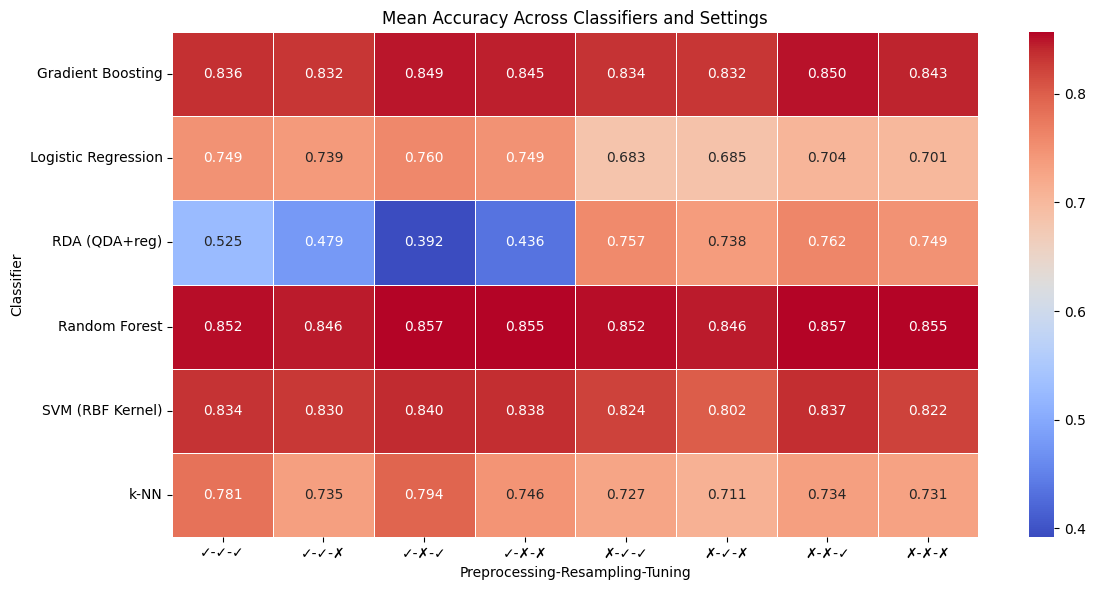

In [54]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all metrics files
metric_paths = glob.glob("results/prep_*_res_*_tune_*/metrics.csv")

records = []
for path in metric_paths:
    # Extract run configuration
    dirname = os.path.basename(os.path.dirname(path))
    prep = dirname.split("_")[1]
    res = dirname.split("_")[3]
    tune = dirname.split("_")[5]

    df = pd.read_csv(path)
    for _, row in df.iterrows():
        records.append({
            "Classifier": row["Classifier"],
            "Preprocessing": "✓" if prep == "1" else "✗",
            "Resampling": "✓" if res == "1" else "✗",
            "Tuning": "✓" if tune == "1" else "✗",
            "Accuracy": row["Accuracy"],
            "Sensitivity": row["Sensitivity"],
            "Specificity": row["Specificity"]
        })

summary_df = pd.DataFrame(records)

# Summary: mean and std
agg = summary_df.groupby(["Classifier", "Preprocessing", "Resampling", "Tuning"]).agg(
    Accuracy_Mean=("Accuracy", "mean"),
    Accuracy_Std=("Accuracy", "std"),
    Sensitivity_Mean=("Sensitivity", "mean"),
    Sensitivity_Std=("Sensitivity", "std"),
    Specificity_Mean=("Specificity", "mean"),
    Specificity_Std=("Specificity", "std"),
).reset_index()

print(agg.round(3))

# Optional: Heatmap of mean accuracy
pivot = summary_df.pivot_table(
    index="Classifier",
    columns=["Preprocessing", "Resampling", "Tuning"],
    values="Accuracy",
    aggfunc="mean"
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Mean Accuracy Across Classifiers and Settings")
plt.tight_layout()
plt.show()



In [6]:
import pandas as pd
import glob
import os

records = []
sample_counts = {"✓": {}, "✗": {}}

# Read all confidence files
for path in glob.glob("results/prep_*_res_*_tune_*/confidence_*.csv"):
    dirname = os.path.basename(os.path.dirname(path))
    resampled = "✓" if "res_1" in dirname else "✗"
    classifier = os.path.basename(path).replace("confidence_", "").replace(".csv", "").replace("_", " ")

    df = pd.read_csv(path)
    df["Correct"] = df["True"] == df["Predicted"]

    # Count sample size per class for reference
    label_counts = df["True"].value_counts()
    for cls, count in label_counts.items():
        key = (classifier, cls)
        sample_counts[resampled][key] = sample_counts[resampled].get(key, []) + [count]

    for cls in sorted(df["True"].unique()):
        df_cls = df[df["True"] == cls]
        acc = df_cls["Correct"].mean()

        records.append({
            "Classifier": classifier,
            "Resampling": resampled,
            "Class": cls,
            "Accuracy": acc
        })

# Convert to DataFrame
df_all = pd.DataFrame(records)

# Pivot to compare ✓ vs. ✗ for each classifier/class pair
pivot = df_all.pivot_table(index=["Classifier", "Class"], columns="Resampling", values="Accuracy", aggfunc="mean")
pivot["Accuracy_Gain_from_Resampling"] = pivot["✓"] - pivot["✗"]

# Add sample size info
samples_before = {k: int(pd.Series(v).mean()) for k, v in sample_counts["✗"].items()}
samples_after = {k: int(pd.Series(v).mean()) for k, v in sample_counts["✓"].items()}

pivot["Samples_Before"] = pivot.index.map(samples_before)
pivot["Samples_After"] = pivot.index.map(samples_after)

# Final output
final = pivot.reset_index()[["Classifier", "Class", "✗", "✓", "Accuracy_Gain_from_Resampling", "Samples_Before", "Samples_After"]]
final.columns = ["Classifier", "Class", "Accuracy_No_Resample", "Accuracy_Resample", "Accuracy_Gain", "Samples_Before", "Samples_After"]

print(final.round(3))


             Classifier  Class  Accuracy_No_Resample  Accuracy_Resample  \
0     Gradient Boosting      1                 0.931              0.863   
1     Gradient Boosting      2                 0.752              0.725   
2     Gradient Boosting      3                 0.820              0.792   
3     Gradient Boosting      4                 0.776              0.790   
4     Gradient Boosting      5                 0.909              0.909   
5     Gradient Boosting      6                 0.765              0.831   
6     Gradient Boosting      7                 0.929              0.944   
7   Logistic Regression      1                 0.729              0.675   
8   Logistic Regression      2                 0.591              0.563   
9   Logistic Regression      3                 0.747              0.724   
10  Logistic Regression      4                 0.692              0.736   
11  Logistic Regression      5                 0.817              0.792   
12  Logistic Regression  

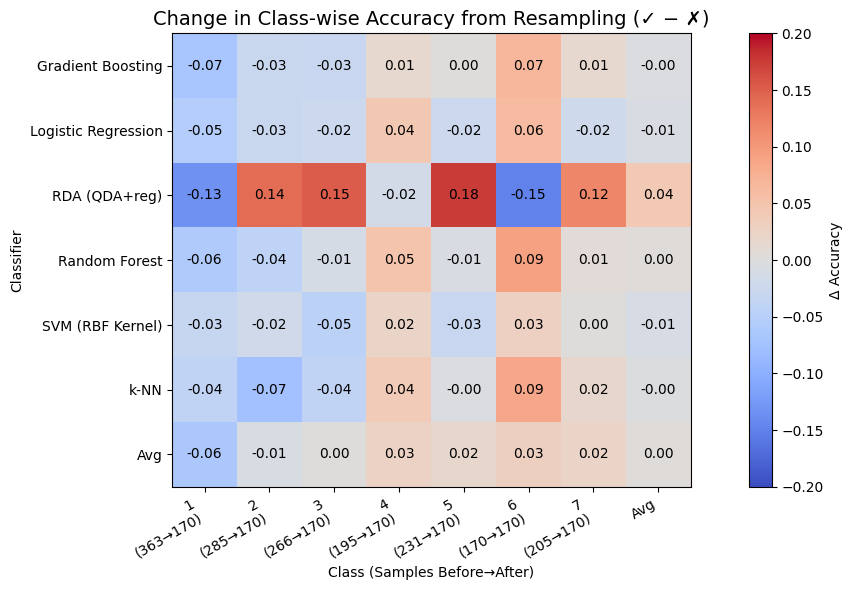

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

records = []
sample_counts = {"✓": {}, "✗": {}}

# --- STEP 1: Collect accuracy and sample size data ---
for path in glob.glob("results/prep_*_res_*_tune_*/confidence_*.csv"):
    dirname = os.path.basename(os.path.dirname(path))
    resampled = "✓" if "res_1" in dirname else "✗"
    classifier = os.path.basename(path).replace("confidence_", "").replace(".csv", "").replace("_", " ")

    df = pd.read_csv(path)
    if not {"True", "Predicted"}.issubset(df.columns):
        continue

    df["Correct"] = df["True"] == df["Predicted"]

    # Store sample counts
    counts = df["True"].value_counts()
    for cls, count in counts.items():
        sample_counts[resampled][cls] = sample_counts[resampled].get(cls, []) + [count]

    for cls in sorted(df["True"].unique()):
        acc = df[df["True"] == cls]["Correct"].mean()
        records.append({
            "Classifier": classifier,
            "Class": cls,
            "Resampling": resampled,
            "Accuracy": acc
        })

# --- STEP 2: Prepare delta accuracy table ---
df_all = pd.DataFrame(records)
pivot = df_all.pivot_table(index=["Classifier", "Class"], columns="Resampling", values="Accuracy", aggfunc="mean")
pivot["Delta"] = pivot["✓"] - pivot["✗"]
delta = pivot["Delta"].unstack(level=1)  # rows = classifiers, cols = classes

# --- STEP 3: Compute average sample sizes per class ---
avg_before = {cls: int(np.mean(v)) for cls, v in sample_counts["✗"].items()}

# --- STEP 4: Add Avg column and row ---
delta["Avg"] = delta.mean(axis=1)  # avg per classifier
avg_row = delta.mean(axis=0).to_frame().T
avg_row.index = ["Avg"]
delta = pd.concat([delta, avg_row])

# --- STEP 5: Create x/y tick labels ---
class_order = delta.columns.tolist()
clf_labels = delta.index.tolist()

class_labels = [
    f"{cls}\n({avg_before.get(cls, '?')}→170)" if cls != "Avg" else "Avg"
    for cls in class_order
]

# --- STEP 6: Plot heatmap ---
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(delta.values, cmap='coolwarm', vmin=-0.2, vmax=0.2)

ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(clf_labels)))
ax.set_xticklabels(class_labels, rotation=30, ha='right')
ax.set_yticklabels(clf_labels)

ax.set_xlabel("Class (Samples Before→After)")
ax.set_ylabel("Classifier")

plt.title("Change in Class-wise Accuracy from Resampling (✓ − ✗)", fontsize=14)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Δ Accuracy")

# Annotate cells
for i in range(len(clf_labels)):
    for j in range(len(class_labels)):
        value = delta.values[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


             Classifier Preprocessing Tuning  Accuracy_Mean  Accuracy_Min  \
0     Gradient Boosting             ✓      ✓          0.842         0.805   
1     Gradient Boosting             ✓      ✗          0.838         0.805   
2     Gradient Boosting             ✗      ✓          0.842         0.805   
3     Gradient Boosting             ✗      ✗          0.838         0.805   
4   Logistic Regression             ✓      ✓          0.755         0.717   
5   Logistic Regression             ✓      ✗          0.744         0.711   
6   Logistic Regression             ✗      ✓          0.694         0.662   
7   Logistic Regression             ✗      ✗          0.693         0.653   
8         RDA (QDA+reg)             ✓      ✓          0.459         0.329   
9         RDA (QDA+reg)             ✓      ✗          0.457         0.423   
10        RDA (QDA+reg)             ✗      ✓          0.759         0.711   
11        RDA (QDA+reg)             ✗      ✗          0.743         0.685   

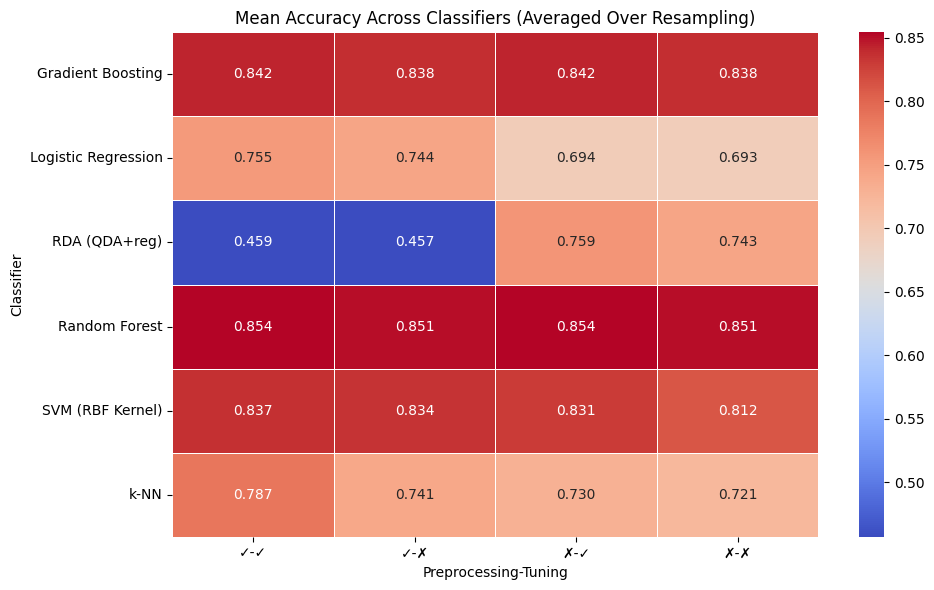

In [59]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all metrics files
metric_paths = glob.glob("results/prep_*_res_*_tune_*/metrics.csv")

records = []
for path in metric_paths:
    dirname = os.path.basename(os.path.dirname(path))
    prep = dirname.split("_")[1]
    tune = dirname.split("_")[5]

    df = pd.read_csv(path)
    for _, row in df.iterrows():
        records.append({
            "Classifier": row["Classifier"],
            "Preprocessing": "✓" if prep == "1" else "✗",
            "Tuning": "✓" if tune == "1" else "✗",
            "Accuracy": row["Accuracy"],
            "Sensitivity": row["Sensitivity"],
            "Specificity": row["Specificity"]
        })

summary_df = pd.DataFrame(records)

# Group by Classifier, Preprocessing, and Tuning only
agg = summary_df.groupby(["Classifier", "Preprocessing", "Tuning"]).agg(
    Accuracy_Mean=("Accuracy", "mean"),
    Accuracy_Min=("Accuracy", "min"),
    Accuracy_Max=("Accuracy", "max"),
    Sensitivity_Mean=("Sensitivity", "mean"),
    Specificity_Mean=("Specificity", "mean")
).reset_index()

print(agg.round(3))

# Optional: Heatmap of mean accuracy
pivot = summary_df.pivot_table(
    index="Classifier",
    columns=["Preprocessing", "Tuning"],
    values="Accuracy",
    aggfunc="mean"
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.title("Mean Accuracy Across Classifiers (Averaged Over Resampling)")
plt.tight_layout()
plt.show()



In [57]:
import pandas as pd
import glob
import os

# === Load all result metrics ===
metric_paths = glob.glob("results/prep_*_res_*_tune_*/metrics.csv")

records = []
for path in metric_paths:
    dirname = path.split(os.sep)[1]
    prep = dirname.split("_")[1]
    res = dirname.split("_")[3]
    tune = dirname.split("_")[5]
    
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        records.append({
            "Classifier": row["Classifier"],
            "Preprocessing": bool(int(prep)),
            "Resampling": bool(int(res)),
            "Tuning": bool(int(tune)),
            "Accuracy": row["Accuracy"]
        })

df_all = pd.DataFrame(records)

# === Compute accuracy difference per classifier for each setting ===
def compute_accuracy_effect(setting):
    grouped = df_all.groupby(["Classifier", setting])["Accuracy"].mean().unstack()
    grouped["Δ_Accuracy"] = grouped[True] - grouped[False]
    return grouped[["Δ_Accuracy"]].rename(columns={"Δ_Accuracy": f"{setting}_effect"})

# Compare each setting
effects = []
for setting in ["Tuning", "Preprocessing", "Resampling"]:
    effect = compute_accuracy_effect(setting).reset_index()
    effect["Setting"] = setting
    effects.append(effect)

df_effects = pd.concat(effects, ignore_index=True)

# Average effect across all classifiers
# Correct average effect computation
avg_tuning = df_effects[df_effects["Setting"] == "Tuning"]["Tuning_effect"].mean()
avg_preproc = df_effects[df_effects["Setting"] == "Preprocessing"]["Preprocessing_effect"].mean()
avg_resample = df_effects[df_effects["Setting"] == "Resampling"]["Resampling_effect"].mean()

avg_effect = pd.DataFrame({
    "Setting": ["Tuning", "Preprocessing", "Resampling"],
    "Average Accuracy Δ": [avg_tuning, avg_preproc, avg_resample]
})

avg_effect = avg_effect.rename(columns={f"{setting}_effect": "Average Accuracy Δ"})

# === Display results ===
print("=== Average Accuracy Effect Across All Classifiers ===")
print(avg_effect.round(3))

print("\n=== Per-Classifier Accuracy Effects ===")
print(df_effects.round(3))



=== Average Accuracy Effect Across All Classifiers ===
         Setting  Average Accuracy Δ
0         Tuning               0.010
1  Preprocessing              -0.031
2     Resampling              -0.003

=== Per-Classifier Accuracy Effects ===
             Classifier  Tuning_effect        Setting  Preprocessing_effect  \
0     Gradient Boosting          0.004         Tuning                   NaN   
1   Logistic Regression          0.006         Tuning                   NaN   
2         RDA (QDA+reg)          0.009         Tuning                   NaN   
3         Random Forest          0.003         Tuning                   NaN   
4      SVM (RBF Kernel)          0.011         Tuning                   NaN   
5                  k-NN          0.028         Tuning                   NaN   
6     Gradient Boosting            NaN  Preprocessing                 0.001   
7   Logistic Regression            NaN  Preprocessing                 0.056   
8         RDA (QDA+reg)            NaN  Prepr

C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


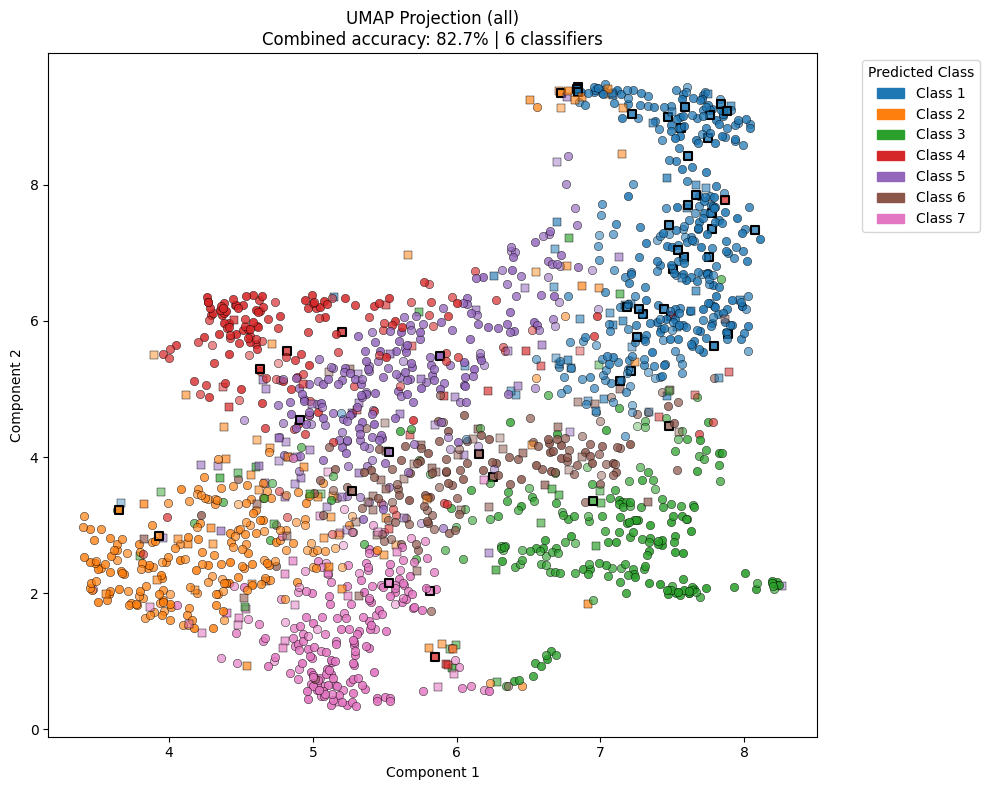

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from glob import glob

# === USER SETTINGS ===
filter_mode = "all"  # Options: "all", "correct", "wrong"
reduction_method = "umap"  # Options: "pca", "tsne", "umap"
selected_classifiers = ["Random_Forest", "Gradient_Boosting", "Logistic_Regression", 
                        "SVM_(RBF_Kernel)", "RDA_(QDA+reg)", "k-NN"]

# === Load original data ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index  # Ensure ID column exists
X = df.drop(columns=["V1", "id"])
y_true = df["V1"].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Load confidence files and align by ID ===
confidence_files = sorted(glob("results/confidence_*.csv"))
clf_data = {}
for f in confidence_files:
    name = f.split("confidence_")[1].split(".csv")[0]
    if name in selected_classifiers:
        conf_df = pd.read_csv(f)
        merged = df[["id"]].merge(conf_df, on="id", how="left")  # Ensure correct alignment
        clf_data[name] = merged

if not clf_data:
    raise ValueError("No matching classifiers found in saved results.")

# === Build matrices
n = len(df)
conf_matrix = np.zeros((n, len(clf_data)))
true_proba_matrix = np.zeros((n, len(clf_data)))
pred_matrix = np.empty((n, len(clf_data)), dtype=object)

for i, (clf_name, clf_df) in enumerate(clf_data.items()):
    conf_matrix[:, i] = clf_df["Confidence"].values
    true_proba_matrix[:, i] = clf_df["TrueLabelProb"].values
    pred_matrix[:, i] = clf_df["Predicted"].values

# === Combine predictions via majority vote
combined_pred = []
for row in pred_matrix:
    valid_preds = row[pd.notna(row)]
    if len(valid_preds) > 0:
        counts = pd.Series(valid_preds).value_counts()
        combined_pred.append(counts.idxmax())
    else:
        combined_pred.append(None)

combined_pred = np.array(combined_pred)
valid_pred_mask = pd.notna(combined_pred)

# === Average confidence
avg_confidence = np.where(valid_pred_mask, conf_matrix.mean(axis=1), 0)

# === Filter points
correct = (combined_pred == y_true) & valid_pred_mask

if filter_mode == "correct":
    mask = correct
elif filter_mode == "wrong":
    mask = (~correct) & valid_pred_mask
else:
    mask = valid_pred_mask

X_vis = X_scaled[mask]
pred_labels = combined_pred[mask]
conf_vals = avg_confidence[mask]

# === Dimensionality reduction
if reduction_method == "pca":
    reducer = PCA(n_components=2)
elif reduction_method == "tsne":
    reducer = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
elif reduction_method == "umap":
    reducer = umap.UMAP(n_components=2, random_state=42)
else:
    raise ValueError("Invalid reduction method")

X_2d = reducer.fit_transform(X_vis)

# === Load highlight indices if available ===
highlight_ids_path = "results/top30_wrong_indices.csv"
highlight_ids = set()

if os.path.exists(highlight_ids_path):
    highlight_df = pd.read_csv(highlight_ids_path)
    highlight_ids = set(highlight_df["index"].values)

# === Determine which samples are highlighted
original_indices = df.index[mask]  # Indices of points after mask applied
highlight_mask = np.array([idx in highlight_ids for idx in original_indices])

# === Plotting with markers and highlight frames
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(X_2d):
    pred_class = pred_labels[i]
    color = to_rgba(class_to_color[pred_class], alpha=np.clip(conf_vals[i], 0.3, 1))
    marker = 's' if combined_pred[original_indices[i]] != y_true[original_indices[i]] else 'o'
    lw = 1.5 if highlight_mask[i] else 0.3
    plt.scatter(x, y, color=color, edgecolor='black', linewidth=lw, marker=marker)

# Accuracy text
accuracy = np.mean(correct) if np.any(valid_pred_mask) else 0
plt.title(f"{reduction_method.upper()} Projection ({filter_mode})\n"
          f"Combined accuracy: {accuracy:.1%} | {len(clf_data)} classifiers")

plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Legend
legend_handles = [Patch(color=class_to_color[cls], label=f"Class {cls}") for cls in unique_classes]
plt.legend(handles=legend_handles, title="Predicted Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [47]:
import pandas as pd
import numpy as np
import os

# === Identify misclassified and confident points ===
combined_pred = np.array(combined_pred)
correct_mask = (combined_pred == y_true)
wrong_mask = ~correct_mask & pd.notna(combined_pred)
conf_sum = conf_matrix.sum(axis=1)

# === Select top 30 most confident but wrong
wrong_confidences = conf_sum[wrong_mask]
top_indices = np.argsort(wrong_confidences)[-50:][::-1]
global_indices = np.where(wrong_mask)[0][top_indices]

# === Build dataframe with detailed info
rows = []
clf_names = list(clf_data.keys())

for idx in global_indices:
    row = {
        "id": df.loc[idx, "id"],
        "True Label": y_true[idx],
        "Combined Prediction": combined_pred[idx],
        "Total Confidence": conf_sum[idx]
    }

    preds = pred_matrix[idx, :]
    preds = preds[pd.notna(preds)]
    row["Votes for Majority"] = pd.Series(preds).value_counts().get(combined_pred[idx], 0)

    for i, clf in enumerate(clf_names):
        row[f"{clf} Prediction"] = pred_matrix[idx, i]
        row[f"{clf} Conf."] = conf_matrix[idx, i]

    rows.append(row)

top30_df = pd.DataFrame(rows)

# === Save to CSVs
os.makedirs("results", exist_ok=True)
top30_df.to_csv("results/top30_wrong_high_confidence.csv", index=False)
pd.DataFrame({"index": global_indices}).to_csv("results/top30_wrong_indices.csv", index=False)

print("✅ Saved detailed results and indices to 'results/'")




✅ Saved detailed results and indices to 'results/'


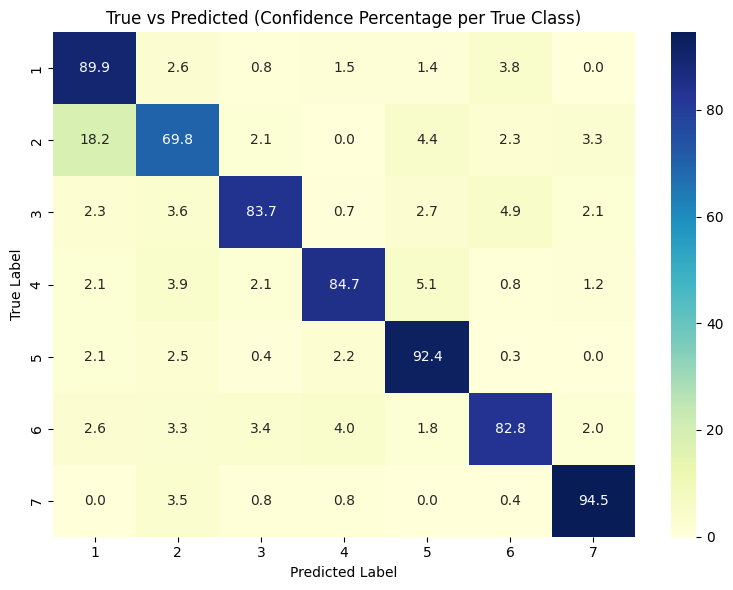

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Prerequisite: You must have these already defined ---
# df["id"], y_true, combined_pred, conf_matrix

# Total confidence per sample
conf_sum = conf_matrix.sum(axis=1)

# Create dataframe with true, predicted, and confidence
summary_df = pd.DataFrame({
    "True": y_true,
    "Predicted": combined_pred,
    "ConfidenceSum": conf_sum
})

# Drop rows with no predictions
summary_df = summary_df.dropna(subset=["Predicted"])

# Group by (True, Predicted) and aggregate total confidence
grouped = summary_df.groupby(["True", "Predicted"]).agg(
    TotalConfidence=("ConfidenceSum", "sum")
).reset_index()

# Pivot and normalize rows to percentage
conf_matrix_df = grouped.pivot(index="True", columns="Predicted", values="TotalConfidence").fillna(0)
conf_matrix_pct = conf_matrix_df.div(conf_matrix_df.sum(axis=1), axis=0) * 100

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("True vs Predicted (Confidence Percentage per True Class)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



In [65]:
#1c
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
from sklearn.base import clone
from itertools import combinations
from sklearn.utils import resample

# Example values to test
k_values = [10, 30, 50]
n_components_list = [10, 30, 50]

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage
all_results = []

# Loop over settings
for k in k_values:
    reducer = SelectKBest(f_classif, k=k)
    for clf_name, clf in classifiers.items():
        acc_scores, sens_scores = [], []
        selected_features = []

        for train_idx, val_idx in cv.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            reducer_fit = clone(reducer).fit(X_train, y_train)
            selected_features.append(set(reducer_fit.get_support(indices=True)))

            X_val = X.iloc[val_idx]
            y_val = y.iloc[val_idx]

            pipe = Pipeline([
                ('reduce', reducer_fit),
                ('clf', clone(clf))
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)

            acc_scores.append(accuracy_score(y_val, y_pred))
            sens_scores.append(recall_score(y_val, y_pred, average='macro'))

        # Feature stability
        jaccards = []
        for a, b in combinations(selected_features, 2):
            jaccards.append(len(a & b) / len(a | b))
        stability = np.mean(jaccards)

        all_results.append({
            "Reduction": f"F-test (k={k})",
            "Classifier": clf_name,
            "Accuracy": np.mean(acc_scores),
            "Sensitivity": np.mean(sens_scores),
            "Stability": stability
        })

for n in n_components_list:
    for method_name, reducer_class in [("PCA", PCA), ("UMAP", UMAP)]:
        for clf_name, clf in classifiers.items():
            acc_scores, sens_scores = [], []
            pred_sets = []

            for train_idx, val_idx in cv.split(X, y):
                X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
                X_val = X.iloc[val_idx]
                y_val = y.iloc[val_idx]

                reducer = reducer_class(n_components=n, random_state=42)
                pipe = Pipeline([
                    ('reduce', reducer),
                    ('clf', clone(clf))
                ])
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_val)
                pred_sets.append(y_pred)

                acc_scores.append(accuracy_score(y_val, y_pred))
                sens_scores.append(recall_score(y_val, y_pred, average='macro'))

            # Stability across folds (prediction agreement)
            agreements = []
            for a, b in combinations(pred_sets, 2):
                same = np.mean(np.array(a) == np.array(b))
                agreements.append(same)
            stability = np.mean(agreements)

            all_results.append({
                "Reduction": f"{method_name} ({n} comps)",
                "Classifier": clf_name,
                "Accuracy": np.mean(acc_scores),
                "Sensitivity": np.mean(sens_scores),
                "Stability": stability
            })

# Show results
final_df = pd.DataFrame(all_results)
print(final_df.round(3).sort_values(by=["Classifier", "Reduction"]))


          Reduction           Classifier  Accuracy  Sensitivity  Stability
2     F-test (k=10)  Logistic Regression     0.689        0.684      0.855
5     F-test (k=30)  Logistic Regression     0.800        0.802      0.924
8     F-test (k=50)  Logistic Regression     0.809        0.809      0.898
11   PCA (10 comps)  Logistic Regression     0.652        0.644      0.153
17   PCA (30 comps)  Logistic Regression     0.734        0.730      0.154
23   PCA (50 comps)  Logistic Regression     0.759        0.757      0.142
14  UMAP (10 comps)  Logistic Regression     0.729        0.714      0.161
20  UMAP (30 comps)  Logistic Regression     0.732        0.716      0.164
26  UMAP (50 comps)  Logistic Regression     0.727        0.715      0.162
0     F-test (k=10)        Random Forest     0.741        0.737      0.855
3     F-test (k=30)        Random Forest     0.863        0.859      0.924
6     F-test (k=50)        Random Forest     0.871        0.864      0.898
9    PCA (10 comps)      

In [ ]:
#2
import os
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

# === Custom Preprocessing ===
class FullPreprocessor:
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std()
        return self
    def transform(self, X):
        return (X - self.means) / self.stds

# === Load data ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index
X_base = df.drop(columns=["V1", "id"])
y_base = df["V1"]
row_ids = df["id"]

# === Define classifiers with optimal parameters ===
classifiers = {
    "Logistic Regression": LogisticRegression(C=0.5908361216819946, max_iter=1000),
    "SVM (RBF Kernel)": SVC(C=1.934347898661638, gamma='auto', probability=True, class_weight='balanced'),
    "k-NN": KNeighborsClassifier(n_neighbors=12),
    "Random Forest": RandomForestClassifier(n_estimators=180, max_depth=9, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=71, learning_rate=0.19524445288831496, max_depth=4, random_state=42),
    "RDA (QDA+reg)": QuadraticDiscriminantAnalysis(reg_param=0.3745401188473625)
}

# === Classifiers that need preprocessing ===
need_preprocessing = {"Logistic Regression", "SVM (RBF Kernel)", "k-NN"}

# === Cross-validation settings ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
output_dir = "results/final_fixed_tuned"
os.makedirs(output_dir, exist_ok=True)

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")
    results = []
    confidence_frames = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_base, y_base)):
        print(f"  Fold {fold+1}/5")
        X_train, y_train = X_base.iloc[train_idx], y_base.iloc[train_idx]
        X_val, y_val = X_base.iloc[val_idx], y_base.iloc[val_idx]
        val_ids = row_ids.iloc[val_idx]

        if name in need_preprocessing:
            preprocessor = FullPreprocessor().fit(X_train)
            X_train_trans = preprocessor.transform(X_train)
            X_val_trans = preprocessor.transform(X_val)
        else:
            X_train_trans = X_train.values
            X_val_trans = X_val.values

        model = clone(clf)
        model.fit(X_train_trans, y_train)
        y_pred = model.predict(X_val_trans)

        acc = accuracy_score(y_val, y_pred)
        sen = recall_score(y_val, y_pred, average='macro')
        spec = (2 * acc - sen)  # Placeholder if specificity_score not available
        results.append((acc, sen, spec))

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_val_trans)
            max_conf = y_proba.max(axis=1)
            pred_labels = y_proba.argmax(axis=1)
            class_indices = {label: idx for idx, label in enumerate(model.classes_)}
            true_label_indices = [class_indices[label] for label in y_val.values]
            true_proba = y_proba[np.arange(len(y_val)), true_label_indices]

            confidence_df = pd.DataFrame({
                "id": val_ids.values,
                "True": y_val.values,
                "Predicted": model.classes_[pred_labels],
                "Confidence": max_conf,
                "TrueLabelProb": true_proba
            })
            confidence_frames.append(confidence_df)

    df_metrics = pd.DataFrame(results, columns=["Accuracy", "Sensitivity", "Specificity"])
    df_metrics["Classifier"] = name
    df_metrics.to_csv(f"{output_dir}/metrics_{name.replace(' ', '_')}.csv", index=False)

    if confidence_frames:
        all_conf = pd.concat(confidence_frames, ignore_index=True)
        all_conf.to_csv(f"{output_dir}/confidence_{name.replace(' ', '_')}.csv", index=False)

print("\n✅ Final tuned runs complete.")
#big boi for 1a!


--- Logistic Regression ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- SVM (RBF Kernel) ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- k-NN ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- Random Forest ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- Gradient Boosting ---
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

--- RDA (QDA+reg) ---
  Fold 1/5
  Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  Fold 3/5
  Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  Fold 5/5

✅ Final tuned runs complete.


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
import os
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

# === Custom Preprocessing ===
class FullPreprocessor:
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std()
        return self
    def transform(self, X):
        return (X - self.means) / self.stds

# === Load data ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index
X_base = df.drop(columns=["V1", "id"])
y_base = df["V1"]
row_ids = df["id"]
classes = np.unique(y_base)

# === Define classifiers with optimal parameters ===
classifiers = {
    "Logistic Regression": LogisticRegression(C=0.5908361216819946, max_iter=1000),
    "SVM (RBF Kernel)": SVC(C=1.934347898661638, gamma='auto', probability=True, class_weight='balanced'),
    "k-NN": KNeighborsClassifier(n_neighbors=12),
    "Random Forest": RandomForestClassifier(n_estimators=180, max_depth=9, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=71, learning_rate=0.19524445288831496, max_depth=4, random_state=42),
    "RDA (QDA+reg)": QuadraticDiscriminantAnalysis(reg_param=0.3745401188473625)
}

need_preprocessing = {"Logistic Regression", "SVM (RBF Kernel)", "k-NN"}

# === Cross-validation settings ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
output_dir = "results/final_fixed_tuned"
os.makedirs(output_dir, exist_ok=True)

all_classwise_results = []

for name, clf in classifiers.items():
    print(f"\n--- {name} ---")

    class_stats = {c: {"accuracy": [], "sensitivity": [], "specificity": []} for c in classes}

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_base, y_base)):
        X_train, y_train = X_base.iloc[train_idx], y_base.iloc[train_idx]
        X_val, y_val = X_base.iloc[val_idx], y_base.iloc[val_idx]

        if name in need_preprocessing:
            preprocessor = FullPreprocessor().fit(X_train)
            X_train = preprocessor.transform(X_train)
            X_val = preprocessor.transform(X_val)
        else:
            X_train = X_train.values
            X_val = X_val.values

        model = clone(clf)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        cm = confusion_matrix(y_val, y_pred, labels=classes)

        for i, cls in enumerate(classes):
            TP = cm[i, i]
            FN = cm[i, :].sum() - TP
            FP = cm[:, i].sum() - TP
            TN = cm.sum() - (TP + FP + FN)

            acc_cls = (TP + TN) / cm.sum()
            sens_cls = TP / (TP + FN) if (TP + FN) > 0 else 0
            spec_cls = TN / (TN + FP) if (TN + FP) > 0 else 0

            class_stats[cls]["accuracy"].append(acc_cls)
            class_stats[cls]["sensitivity"].append(sens_cls)
            class_stats[cls]["specificity"].append(spec_cls)

    for cls in classes:
        all_classwise_results.append({
            "Classifier": name,
            "Class": cls,
            "Avg_Accuracy": np.mean(class_stats[cls]["accuracy"]),
            "Min_Accuracy": np.min(class_stats[cls]["accuracy"]),
            "Max_Accuracy": np.max(class_stats[cls]["accuracy"]),
            "Avg_Sensitivity": np.mean(class_stats[cls]["sensitivity"]),
            "Min_Sensitivity": np.min(class_stats[cls]["sensitivity"]),
            "Max_Sensitivity": np.max(class_stats[cls]["sensitivity"]),
            "Avg_Specificity": np.mean(class_stats[cls]["specificity"]),
            "Min_Specificity": np.min(class_stats[cls]["specificity"]),
            "Max_Specificity": np.max(class_stats[cls]["specificity"]),
        })

# === Save single result file
df_final = pd.DataFrame(all_classwise_results)
df_final.to_csv("results/classwise_summary.csv", index=False)
print("✅ Saved to results/classwise_summary.csv")
#1a class wise


--- Logistic Regression ---

--- SVM (RBF Kernel) ---

--- k-NN ---

--- Random Forest ---

--- Gradient Boosting ---

--- RDA (QDA+reg) ---


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va

✅ Saved to results/classwise_summary.csv


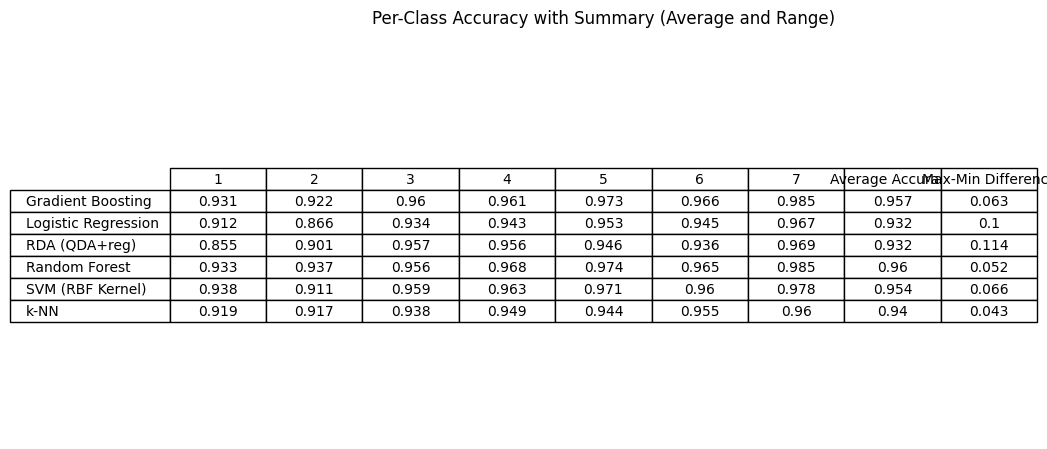

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
df = pd.read_csv("results/classwise_summary.csv")

# Pivot to get a table with Classifiers as rows and Classes as columns
pivot_acc = df.pivot(index="Classifier", columns="Class", values="Avg_Accuracy")

# Add summary columns
pivot_acc["Average Accuracy"] = pivot_acc.mean(axis=1)
pivot_acc["Max-Min Difference"] = pivot_acc.max(axis=1) - pivot_acc.min(axis=1)

# Round for presentation
pivot_acc_display = pivot_acc.round(3)

# === Plot as table ===
fig, ax = plt.subplots(figsize=(pivot_acc.shape[1] * 1.2, len(pivot_acc) * 0.6 + 1))
ax.axis('off')

table = ax.table(
    cellText=pivot_acc_display.values,
    rowLabels=pivot_acc_display.index,
    colLabels=pivot_acc_display.columns,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Per-Class Accuracy with Summary (Average and Range)", pad=20)
plt.tight_layout()
plt.show()


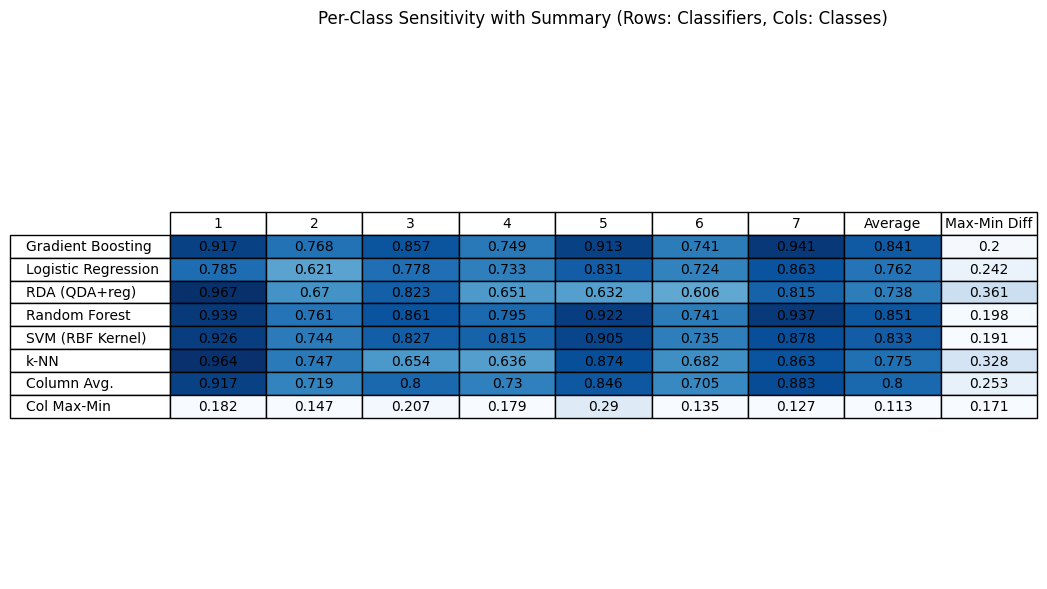

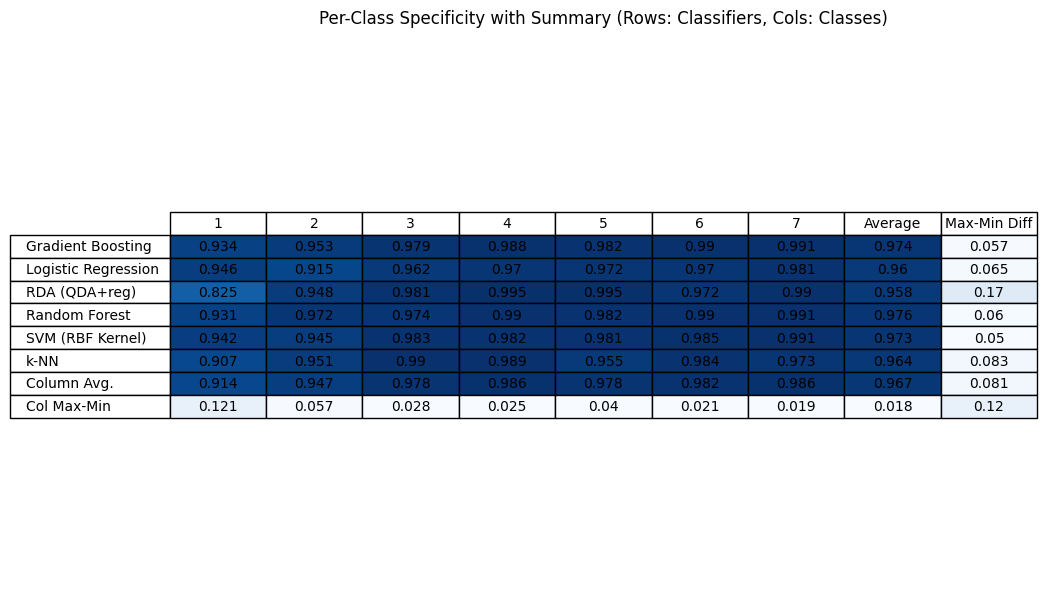

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Load data ===
df = pd.read_csv("results/classwise_summary.csv")

def plot_metric_table(df, value_col, title):
    pivot = df.pivot(index="Classifier", columns="Class", values=value_col)

    # Add classifier-level summaries
    pivot["Average"] = pivot.mean(axis=1)
    pivot["Max-Min Diff"] = pivot.max(axis=1) - pivot.min(axis=1)

    # Add class-level summaries
    avg_row = pivot.mean(axis=0).to_frame().T
    avg_row.index = ["Column Avg."]
    diff_row = (pivot.max(axis=0) - pivot.min(axis=0)).to_frame().T
    diff_row.index = ["Col Max-Min"]

    # Combine full table
    pivot_full = pd.concat([pivot, avg_row, diff_row])
    pivot_display = pivot_full.round(3)

    # Plot setup
    fig, ax = plt.subplots(figsize=(pivot_full.shape[1] * 1.2, len(pivot_full) * 0.6 + 1.2))
    ax.axis('off')

    # Normalize values for colormap
    norm = plt.Normalize(pivot.min().min(), pivot.max().max())
    cmap = plt.cm.Blues

    # Create table
    table = ax.table(
        cellText=pivot_display.values,
        rowLabels=pivot_display.index,
        colLabels=pivot_display.columns,
        loc='center',
        cellLoc='center'
    )

    # Color each cell by value
    for (i, j), cell in table.get_celld().items():
        if i == 0 or j == -1:  # Header row or column
            continue
        value = pivot_display.iloc[i - 1, j] if i - 1 < len(pivot_display) else np.nan
        if not pd.isna(value):
            color = cmap(norm(value))
            cell.set_facecolor(color)
            cell.set_text_props(color='black')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(title, pad=20)
    plt.tight_layout()
    plt.show()

# === Plot sensitivity and specificity tables ===
plot_metric_table(df, "Avg_Sensitivity", "Per-Class Sensitivity with Summary (Rows: Classifiers, Cols: Classes)")
plot_metric_table(df, "Avg_Specificity", "Per-Class Specificity with Summary (Rows: Classifiers, Cols: Classes)")


In [30]:
#2.1
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

# === Custom Preprocessing ===
class FullPreprocessor:
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std()
        return self
    def transform(self, X):
        return (X - self.means) / self.stds

# === Load data ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index
X_base = df.drop(columns=["V1", "id"])
y_base = df["V1"]
row_ids = df["id"]
classes = y_base.unique()

# === Define classifiers with optimal parameters ===
classifiers = {
    "Logistic Regression": LogisticRegression(C=0.5908361216819946, max_iter=1000),
    "SVM (RBF Kernel)": SVC(C=1.934347898661638, gamma='auto', probability=True, class_weight='balanced'),
    "k-NN": KNeighborsClassifier(n_neighbors=12),
    "Random Forest": RandomForestClassifier(n_estimators=180, max_depth=9, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=71, learning_rate=0.19524445288831496, max_depth=4, random_state=42),
    "RDA (QDA+reg)": QuadraticDiscriminantAnalysis(reg_param=0.3745401188473625)
}

need_preprocessing = {"Logistic Regression", "SVM (RBF Kernel)", "k-NN"}

# === Cross-validation settings ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
noise_levels = [0.02, 0.05, 0.10, 0.20, 0.30, 0.50, 0.80, 0.90]

results = []

for noise in noise_levels:
    print(f"\n=== Noise Level: {int(noise * 100)}% mislabeling ===")
    for name, clf in classifiers.items():
        accs = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X_base, y_base)):
            X_train, y_train = X_base.iloc[train_idx], y_base.iloc[train_idx].copy()
            X_val, y_val = X_base.iloc[val_idx], y_base.iloc[val_idx]

            # Introduce mislabeling in training labels
            n_mislabel = int(len(y_train) * noise)
            mislabel_idx = np.random.choice(y_train.index, size=n_mislabel, replace=False)

            for idx in mislabel_idx:
                y_train.at[idx] = np.random.choice([c for c in classes if c != y_train.at[idx]])

            if name in need_preprocessing:
                preprocessor = FullPreprocessor().fit(X_train)
                X_train = preprocessor.transform(X_train)
                X_val = preprocessor.transform(X_val)
            else:
                X_train = X_train.values
                X_val = X_val.values

            model = clone(clf)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            acc = accuracy_score(y_val, y_pred)
            accs.append(acc)

        results.append({
            "Classifier": name,
            "Noise_Level": f"{int(noise * 100)}%",
            "CV_Accuracy_Mean": np.mean(accs),
            "CV_Accuracy_Std": np.std(accs)
        })

# Save and show results
df_results = pd.DataFrame(results)
df_results.to_csv("results/noise_impact_study.csv", index=False)
print("\n✅ Saved to results/noise_impact_study.csv")
print(df_results.pivot(index="Classifier", columns="Noise_Level", values="CV_Accuracy_Mean").round(3))




=== Noise Level: 2% mislabeling ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va


=== Noise Level: 5% mislabeling ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va


=== Noise Level: 10% mislabeling ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va


=== Noise Level: 20% mislabeling ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va


=== Noise Level: 30% mislabeling ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va


=== Noise Level: 50% mislabeling ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va


=== Noise Level: 80% mislabeling ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va


=== Noise Level: 90% mislabeling ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va


✅ Saved to results/noise_impact_study.csv
Noise_Level            10%     2%    20%    30%     5%    50%    80%    90%
Classifier                                                                 
Gradient Boosting    0.816  0.842  0.772  0.703  0.829  0.508  0.179  0.122
Logistic Regression  0.619  0.732  0.582  0.507  0.654  0.425  0.187  0.110
RDA (QDA+reg)        0.652  0.742  0.604  0.544  0.715  0.406  0.191  0.115
Random Forest        0.854  0.859  0.851  0.836  0.850  0.786  0.222  0.101
SVM (RBF Kernel)     0.834  0.841  0.797  0.762  0.841  0.669  0.231  0.086
k-NN                 0.778  0.791  0.761  0.717  0.786  0.613  0.210  0.108


In [33]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.base import clone

# === Preprocessing ===
class FullPreprocessor:
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std()
        return self
    def transform(self, X):
        return (X - self.means) / self.stds

# === Load dataset ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index
X_full = df.drop(columns=["V1", "id"])
y_full = df["V1"]
classes = np.sort(y_full.unique())

# === Classifiers and preprocessing flag ===
classifiers = {
    "Logistic Regression": (LogisticRegression(C=0.5908, max_iter=1000), True),
    "SVM (RBF Kernel)": (SVC(C=1.934, gamma='auto', probability=True, class_weight='balanced'), True),
    "k-NN": (KNeighborsClassifier(n_neighbors=12), True),
    "Random Forest": (RandomForestClassifier(n_estimators=180, max_depth=9, random_state=42), False),
    "Gradient Boosting": (GradientBoostingClassifier(n_estimators=71, learning_rate=0.1952, max_depth=4, random_state=42), False),
    "RDA (QDA+reg)": (QuadraticDiscriminantAnalysis(reg_param=0.3745), False)
}

# === Relabel settings ===
original_class = 4
new_class = 7
noise_levels = [0.02, 0.05, 0.10, 0.20, 0.30, 0.50, 0.80, 0.90]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
os.makedirs("results/noise_eval", exist_ok=True)

for clf_name, (clf, needs_pre) in classifiers.items():
    print(f"\n=== {clf_name} ===")
    all_rows = []

    for frac in noise_levels:
        np.random.seed(42)
        y = y_full.copy()
        X = X_full.copy()

        relabel_idx = y[y == original_class].sample(frac=frac).index
        status = pd.Series("normal", index=y.index)
        status.loc[relabel_idx] = "relabeled"
        y.loc[relabel_idx] = new_class

        picked_real_4 = 0
        total_relabeled = 0
        picked_fake_7 = 0
        total_true_4 = 0

        class_stats = {c: {"acc": [], "sen": [], "spec": []} for c in classes}

        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
            status_test = status.iloc[test_idx]
            y_orig_test = y_full.iloc[test_idx]

            if needs_pre:
                prep = FullPreprocessor().fit(X_train)
                X_train = prep.transform(X_train)
                X_test = prep.transform(X_test)
            else:
                X_train = X_train.values
                X_test = X_test.values

            model = clone(clf)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            for true_orig, tag, pred in zip(y_orig_test, status_test, y_pred):
                if tag == "relabeled":
                    total_relabeled += 1
                    if pred == original_class:
                        picked_real_4 += 1
                elif tag == "normal" and true_orig == original_class:
                    total_true_4 += 1
                    if pred == new_class:
                        picked_fake_7 += 1

            cm = confusion_matrix(y_orig_test, y_pred, labels=classes)
            for i, cls in enumerate(classes):
                TP = cm[i, i]
                FN = cm[i, :].sum() - TP
                FP = cm[:, i].sum() - TP
                TN = cm.sum() - (TP + FP + FN)
                acc = (TP + TN) / cm.sum()
                sen = TP / (TP + FN) if (TP + FN) > 0 else 0
                spec = TN / (TN + FP) if (TN + FP) > 0 else 0
                class_stats[cls]["acc"].append(acc)
                class_stats[cls]["sen"].append(sen)
                class_stats[cls]["spec"].append(spec)

        for cls in classes:
            all_rows.append({
                "NoiseLevel": frac,
                "Classifier": clf_name,
                "Class": cls,
                "Accuracy": np.mean(class_stats[cls]["acc"]),
                "Sensitivity": np.mean(class_stats[cls]["sen"]),
                "Specificity": np.mean(class_stats[cls]["spec"]),
                "Recovered_class4": picked_real_4 / total_relabeled if total_relabeled > 0 else np.nan,
                "Mistaken_as_7": picked_fake_7 / total_true_4 if total_true_4 > 0 else np.nan
            })

    pd.DataFrame(all_rows).to_csv(f"results/noise_eval/{clf_name.replace(' ', '_')}_noise_results.csv", index=False)
    print(f"Saved to results/noise_eval/{clf_name.replace(' ', '_')}_noise_results.csv")



=== Logistic Regression ===
Saved to results/noise_eval/Logistic_Regression_noise_results.csv

=== SVM (RBF Kernel) ===
Saved to results/noise_eval/SVM_(RBF_Kernel)_noise_results.csv

=== k-NN ===
Saved to results/noise_eval/k-NN_noise_results.csv

=== Random Forest ===
Saved to results/noise_eval/Random_Forest_noise_results.csv

=== Gradient Boosting ===
Saved to results/noise_eval/Gradient_Boosting_noise_results.csv

=== RDA (QDA+reg) ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va

Saved to results/noise_eval/RDA_(QDA+reg)_noise_results.csv


In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

# === Load data ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index
X_base = df.drop(columns=["V1", "id"]).copy()
y_base = df["V1"].copy()

# === Standardize features ===
X_mean = X_base.mean()
X_std = X_base.std()
X_standardized = (X_base - X_mean) / X_std

# === Define classifiers (no Gradient Boosting for speed) ===
classifiers = {
    "Logistic Regression": LogisticRegression(C=0.5908361216819946, max_iter=1000),
    "SVM (RBF Kernel)": SVC(C=1.934347898661638, gamma='auto', probability=True, class_weight='balanced'),
    "k-NN": KNeighborsClassifier(n_neighbors=12),
    "Random Forest": RandomForestClassifier(n_estimators=180, max_depth=9, random_state=42),
    "RDA (QDA+reg)": QuadraticDiscriminantAnalysis(reg_param=0.3745401188473625)
}

# === Noise levels to test ===
noise_levels = [0.0, 0.05, 0.1, 0.4, 0.6, 0.8, 1.0, 1.5,2,3]

# === Cross-validation setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Collect results ===
all_results = []

for noise_std in noise_levels:
    # Add noise to standardized data
    np.random.seed(42)
    noise = np.random.normal(0, noise_std, size=X_standardized.shape)
    X_noisy = X_standardized + noise

    for name, clf in classifiers.items():
        accs = []
        sens = []

        for train_idx, val_idx in cv.split(X_noisy, y_base):
            X_train, X_val = X_noisy.iloc[train_idx], X_noisy.iloc[val_idx]
            y_train, y_val = y_base.iloc[train_idx], y_base.iloc[val_idx]

            model = clone(clf)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            accs.append(accuracy_score(y_val, y_pred))
            sens.append(recall_score(y_val, y_pred, average='macro'))

        all_results.append({
            "NoiseSTD": noise_std,
            "Classifier": name,
            "Accuracy": np.mean(accs),
            "Sensitivity": np.mean(sens)
        })

# === Save results ===
df_results = pd.DataFrame(all_results)
df_results.to_csv("results/noise_injection_standardized.csv", index=False)
print(df_results.round(3))


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va

    NoiseSTD           Classifier  Accuracy  Sensitivity
0       0.00  Logistic Regression     0.760        0.762
1       0.00     SVM (RBF Kernel)     0.840        0.833
2       0.00                 k-NN     0.791        0.775
3       0.00        Random Forest     0.859        0.851
4       0.00        RDA (QDA+reg)     0.432        0.451
5       0.05  Logistic Regression     0.755        0.758
6       0.05     SVM (RBF Kernel)     0.841        0.833
7       0.05                 k-NN     0.791        0.773
8       0.05        Random Forest     0.850        0.842
9       0.05        RDA (QDA+reg)     0.429        0.450
10      0.10  Logistic Regression     0.751        0.753
11      0.10     SVM (RBF Kernel)     0.838        0.830
12      0.10                 k-NN     0.789        0.772
13      0.10        Random Forest     0.851        0.842
14      0.10        RDA (QDA+reg)     0.426        0.450
15      0.40  Logistic Regression     0.717        0.718
16      0.40     SVM (RBF Kerne

C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [3]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Nils\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


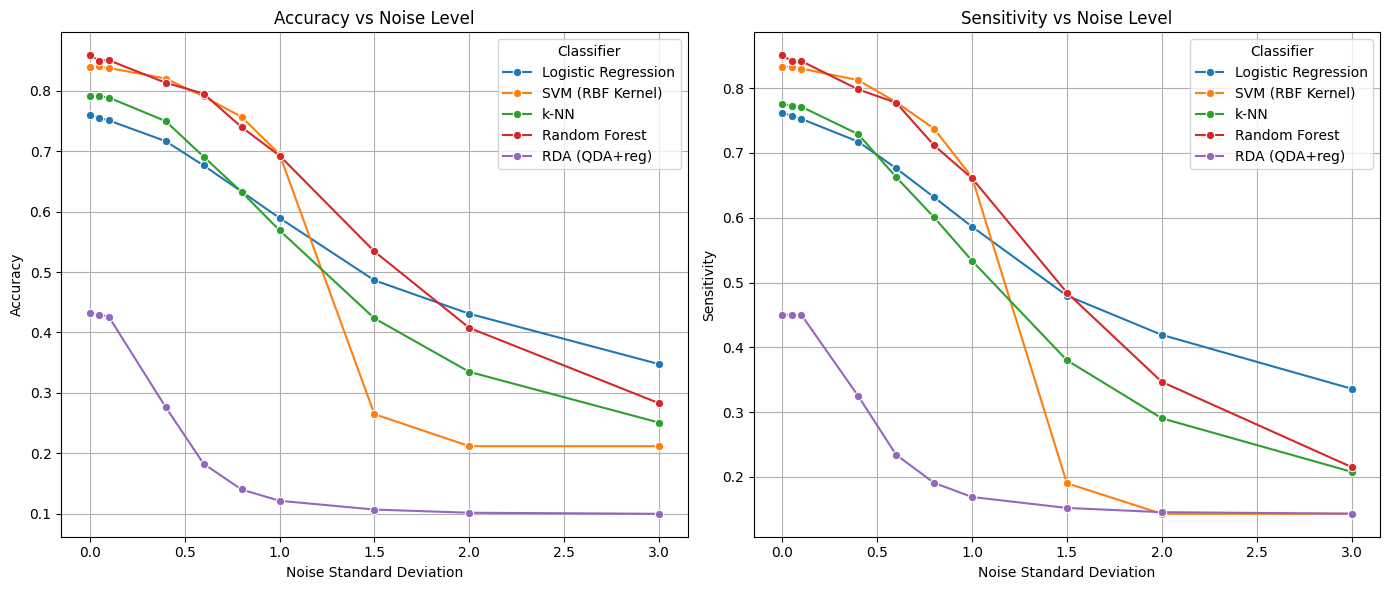

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load results ===
df = pd.read_csv("results/noise_injection_standardized.csv")

# === Plot Accuracy and Sensitivity vs NoiseSTD ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Accuracy Plot
sns.lineplot(data=df, x="NoiseSTD", y="Accuracy", hue="Classifier", marker="o", ax=axes[0])
axes[0].set_title("Accuracy vs Noise Level")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("Noise Standard Deviation")
axes[0].grid(True)

# Sensitivity Plot
sns.lineplot(data=df, x="NoiseSTD", y="Sensitivity", hue="Classifier", marker="o", ax=axes[1])
axes[1].set_title("Sensitivity vs Noise Level")
axes[1].set_ylabel("Sensitivity")
axes[1].set_xlabel("Noise Standard Deviation")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.base import clone

# === Preprocessing ===
class FullPreprocessor:
    def fit(self, X):
        self.means = X.mean()
        self.stds = X.std()
        return self
    def transform(self, X):
        return (X - self.means) / self.stds

# === Load dataset ===
df = pd.read_csv("Cancer2025exam.csv")
df["id"] = df.index
X_full = df.drop(columns=["V1", "id"])
y_full = df["V1"]
classes = np.sort(y_full.unique())

# === Classifiers and preprocessing flag ===
classifiers = {
    "Logistic Regression": (LogisticRegression(C=0.5908, max_iter=1000), True),
    "SVM (RBF Kernel)": (SVC(C=1.934, gamma='auto', probability=True, class_weight='balanced'), True),
    "k-NN": (KNeighborsClassifier(n_neighbors=12), True),
    "Random Forest": (RandomForestClassifier(n_estimators=180, max_depth=9, random_state=42), False),
    "Gradient Boosting": (GradientBoostingClassifier(n_estimators=71, learning_rate=0.1952, max_depth=4, random_state=42), False),
    "RDA (QDA+reg)": (QuadraticDiscriminantAnalysis(reg_param=0.3745), False)
}

# === Settings ===
target_class = 4
noise_levels = [0.02, 0.05, 0.10, 0.20, 0.30, 0.50, 0.80, 0.90]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
os.makedirs("results/classnoise_eval", exist_ok=True)

for clf_name, (clf, needs_pre) in classifiers.items():
    print(f"\n=== {clf_name} ===")
    all_rows = []

    for noise_std in noise_levels:
        np.random.seed(42)
        X = X_full.copy()
        y = y_full.copy()

        # Apply noise to features of one class only
        idx_target_class = y[y == target_class].index
        noise = np.random.normal(loc=0, scale=noise_std, size=X.loc[idx_target_class].shape)
        X.loc[idx_target_class] += noise

        class_stats = {c: {"acc": [], "sen": [], "spec": []} for c in classes}

        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

            if needs_pre:
                prep = FullPreprocessor().fit(X_train)
                X_train = prep.transform(X_train)
                X_test = prep.transform(X_test)
            else:
                X_train = X_train.values
                X_test = X_test.values

            model = clone(clf)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            cm = confusion_matrix(y_test, y_pred, labels=classes)
            for i, cls in enumerate(classes):
                TP = cm[i, i]
                FN = cm[i, :].sum() - TP
                FP = cm[:, i].sum() - TP
                TN = cm.sum() - (TP + FP + FN)
                acc = (TP + TN) / cm.sum()
                sen = TP / (TP + FN) if (TP + FN) > 0 else 0
                spec = TN / (TN + FP) if (TN + FP) > 0 else 0
                class_stats[cls]["acc"].append(acc)
                class_stats[cls]["sen"].append(sen)
                class_stats[cls]["spec"].append(spec)

        for cls in classes:
            all_rows.append({
                "NoiseSTD": noise_std,
                "Classifier": clf_name,
                "Class": cls,
                "Accuracy": np.mean(class_stats[cls]["acc"]),
                "Sensitivity": np.mean(class_stats[cls]["sen"]),
                "Specificity": np.mean(class_stats[cls]["spec"]),
            })

    pd.DataFrame(all_rows).to_csv(f"results/classnoise_eval/{clf_name.replace(' ', '_')}_featureNoise_class{target_class}.csv", index=False)
    print(f"Saved to results/classnoise_eval/{clf_name.replace(' ', '_')}_featureNoise_class{target_class}.csv")



=== Logistic Regression ===
Saved to results/classnoise_eval/Logistic_Regression_featureNoise_class4.csv

=== SVM (RBF Kernel) ===
Saved to results/classnoise_eval/SVM_(RBF_Kernel)_featureNoise_class4.csv

=== k-NN ===
Saved to results/classnoise_eval/k-NN_featureNoise_class4.csv

=== Random Forest ===
Saved to results/classnoise_eval/Random_Forest_featureNoise_class4.csv

=== Gradient Boosting ===
Saved to results/classnoise_eval/Gradient_Boosting_featureNoise_class4.csv

=== RDA (QDA+reg) ===


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Va

Saved to results/classnoise_eval/RDA_(QDA+reg)_featureNoise_class4.csv


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
